# Basic optimization

In [1]:
from contra_qa.text_generation.boolean2_S_and import boolean2
from contra_qa.text_processing.functions import simple_pre_process_text_df
from contra_qa.plots.functions  import plot_histogram_from_labels, plot_confusion_matrix, simple_step_plot

from contra_qa.train_functions.RNNConfig import RNNConfig
import numpy as np
import torch
import torch.nn as nn
from torchtext import data

import pandas as pd
import  matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

% matplotlib inline

In [2]:
boolean2()
df2 = pd.read_csv("data/boolean2_train.csv")

In [3]:
df2.tail()

,sentence1,sentence2,and_A,and_B,label
9995,Herman is wonderful and Kayla is poor,Kayla is not wonderful,Herman is wonderful,Kayla is poor,0
9996,Fernando is proud and Anne is unimportant,Anne is not proud,Fernando is proud,Anne is unimportant,0
9997,Wallace is calm and Pedro is inexpensive,Wallace is not inexpensive,Wallace is calm,Pedro is inexpensive,0
9998,Elizabeth is better and Emily is inexpensive,Emily is not inexpensive,Elizabeth is better,Emily is inexpensive,1
9999,Harvey is jolly and Christopher is rich,Harvey is not rich,Harvey is jolly,Christopher is rich,0


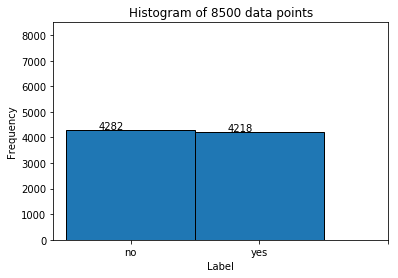

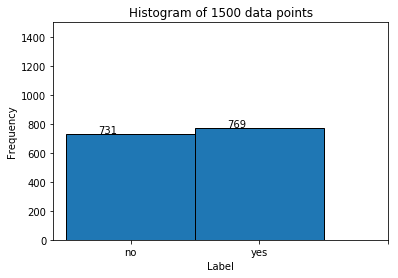

In [4]:
df2train = df2.iloc[:8500]
df2valid = df2.iloc[8500:]
plot_histogram_from_labels(df2train.label.values, ["no", "yes"], "test.png") 
plot_histogram_from_labels(df2valid.label.values, ["no", "yes"], "test.png")

In [5]:
simple_pre_process_text_df(df2, "sentence1")
simple_pre_process_text_df(df2, "sentence2")
simple_pre_process_text_df(df2, "and_A")
simple_pre_process_text_df(df2, "and_B")

df2["text"] = df2["sentence1"] + ", " + df2["sentence2"]
df2_little = df2[["text", "label"]]

df2_little.head()

,text,label
0,"marvin is proud and bessie is proud, marvin is...",1
1,"terrance is lively and judith is zealous, terr...",1
2,"connie is vast and lorraine is dead, lorraine ...",1
3,"kirk is proud and crystal is victorious, kirk ...",1
4,"marie is clever and angela is helpful, angela ...",1


In [6]:
train_data_path = "data/boolean_2_train_lab.csv"
df2_little.to_csv(train_data_path, header=False, index=False)
TEXT = data.Field()
LABEL = data.LabelField(tensor_type=torch.FloatTensor)
train = data.TabularDataset(path=train_data_path,
                            format="csv",
                            fields=[('text', TEXT), ('label', LABEL)])
TEXT.build_vocab(train, max_size=25000)
LABEL.build_vocab(train)

In [7]:
print('len(TEXT.vocab):', len(TEXT.vocab))
print('len(LABEL.vocab):', len(LABEL.vocab))

len(TEXT.vocab): 753
len(LABEL.vocab): 2


In [8]:
def finde_size(list_):
    return np.max(list(map(lambda x: len(x.split(" ")), list_)))

In [9]:
def str_list2tensor(list_):
    list_i = []
    max_size = finde_size(list_)
    for line in list_:
        line = line.split(" ")
        size = len(line) 
        tail = max_size - size
        line += [TEXT.pad_token] * tail
        new_line = [TEXT.vocab.stoi[word] for word in line]
        list_i.append(new_line)
    return torch.tensor(list_i, dtype=torch.long, device=device)

In [10]:
s1_t = str_list2tensor(list(df2train.sentence1.values))
y_t = torch.tensor(list(df2train.label.values),
                   dtype=torch.long,
                   device=device)

In [11]:
from torch.utils.data import TensorDataset

train_dataset = TensorDataset(s1_t, s1_t, s1_t, s1_t, y_t)
valid_dataset = TensorDataset(s1_t, s1_t, s1_t, s1_t, y_t)
test_dataset = TensorDataset(s1_t, s1_t, s1_t, s1_t, y_t)

In [12]:
from torch.utils.data import DataLoader

class DataHolder():
    """
    Class to store all data using the GentleLoader.

    :param config: hyper params configuration
    :type config: LRConfig or DFNConfig
    :param train_dataset: dataset of training data
    :type train_dataset: torch.utils.data.dataset.TensorDataset
    :param test_dataset: dataset of test data
    :type test_dataset: torch.utils.data.dataset.TensorDataset
    :param valid_dataset: dataset of valid data
    :type valid_dataset: torch.utils.data.dataset.TensorDataset
    :param batch_size: batch size for training
    :type test_batch: batch size for the testing data
    :param test_batch: int
    """
    def __init__(self,
                 config,
                 train_dataset,
                 valid_dataset,
                 test_dataset,
                 test_batch=1000):
        batch_size = config.batch_size
        self.train_loader = DataLoader(dataset=train_dataset,
                                         batch_size=batch_size,
                                         shuffle=True)
        self.valid_loader = DataLoader(dataset=valid_dataset,
                                         batch_size=batch_size,
                                         shuffle=True)
        self.test_loader = DataLoader(dataset=test_dataset,
                                        batch_size=test_batch,
                                        shuffle=True)

In [13]:
config = RNNConfig(vocab_size=len(TEXT.vocab),
                   output_dim=len(LABEL.vocab),
                   embedding_dim=10,
                   rnn_dim=10,
                   learning_rate=0.02)

test_data = DataHolder(config,
                    train_dataset,
                    valid_dataset,
                    test_dataset)

In [14]:
class AddRNN(nn.Module):
    def __init__(self, config):
        super(AddRNN, self).__init__()
        self.vocab_size = config.vocab_size
        self.embedding_dim = config.embedding_dim
        self.output_dim = config.output_dim
        self.rnn_dim = config.rnn_dim
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.rnn = nn.RNN(self.embedding_dim, self.rnn_dim) 
        self.fc_out = nn.Linear(self.rnn_dim, self.output_dim)

    def forward(self, x, hidden):
        """
        Apply the model to the input x
        :param x: indices of the sentence
        :type x: torch.Tensor(shape=[sent len, batch size]
                              dtype=torch.int64)
        """
        embedded = self.embedding(x)
        if hidden is None:
            hidden = torch.zeros(1,
                                 embedded.shape[0],
                                 self.rnn_dim,
                                 device=device)
        embedded = embedded.view((1, embedded.shape[0], embedded.shape[1]))
        output, hidden = self.rnn(embedded)
        # output = [sent len, batch size, hid dim]
        # hidden = [1, batch size, hid dim]
        output = self.fc_out(output)
        return output, hidden

    def predict(self, x):
        out, _ = self.forward(x)
        softmax = nn.Softmax(dim=1)
        out = softmax(out)
        indices = torch.argmax(out, 1)
        return indices

In [15]:
def train_in_epoch(model, iterator, optimizer, criterion):
    """
    Train the model using all the data from the iterator
    Negative is a flag to train the model to maximize the
    loss function
    :param model: RNN classification model
    :type model: RNN
    :param iterator: data iterator
    :type iterator: data.BucketIterator
    :param optimizer: torch optimizer
    :type optimizer: optim.SGD, etc.
    :param criterion: loss criterion
    :type criterion: nn.CrossEntropyLoss
    :param negative: control param
    :type negative: boolean
    :return: mean loss, mean accuracy
    :rtype: float, float
    """

    epoch_loss = []
    epoch_acc = []

    model.train()

    for batch in iterator:

        optimizer.zero_grad()
        s1, s2, ha, hb, label = batch
        s1 = s1.view(s1.shape[1], s1.shape[0])
        s1_length = s1.size(0)
        hidden = None
        for di in range(s1_length):
            output, hidden = model(s1[di], hidden)
            output = output.view((output.shape[1], output.shape[2]))

        # loss
        loss = criterion(output, label)
        epoch_loss.append(loss.item())
        
        # accuracy
        softmax = nn.Softmax(dim=1)
        output = softmax(output)
        pred = torch.argmax(output, 1)
        acc = np.mean(torch.eq(pred, label).numpy())
        epoch_loss.append(loss.item())
        epoch_acc.append(acc)

        loss.backward(retain_graph=False)
        optimizer.step()

    return epoch_loss, epoch_acc

In [16]:
config = RNNConfig(vocab_size=len(TEXT.vocab),
                   output_dim=len(LABEL.vocab),
                   embedding_dim=10,
                   rnn_dim=20,
                   learning_rate=0.247,
                   momentum=0.0,
                   epochs=25)
model = AddRNN(config)
iterator = test_data.train_loader
optimizer = torch.optim.SGD(model.parameters(),
                            lr=config.learning_rate,
                            momentum=config.momentum)
criterion = nn.CrossEntropyLoss()
loss, acc = train_in_epoch(model,
                           iterator,
                           optimizer,
                           criterion)

## Vizualizing the train loss and acc during epochs

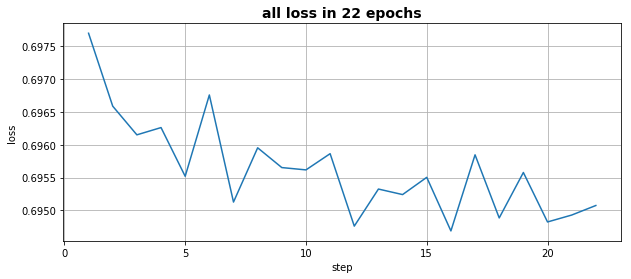

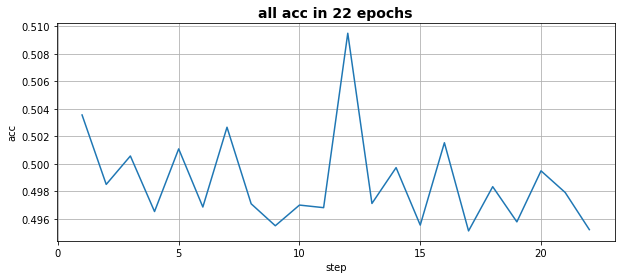

In [18]:
config = RNNConfig(vocab_size=len(TEXT.vocab),
                   output_dim=len(LABEL.vocab),
                   embedding_dim=100,
                   rnn_dim=200,
                   learning_rate=0.01547,
                   momentum=0.0,
                   epochs=22)


model = AddRNN(config)
iterator = test_data.train_loader
optimizer = torch.optim.SGD(model.parameters(),
                            lr=config.learning_rate,
                            momentum=config.momentum)

    
criterion = nn.CrossEntropyLoss()

all_loss = []
all_acc = []

epochs = config.epochs

for i in range(epochs):
    loss, acc = train_in_epoch(model,
                               iterator,
                               optimizer,
                               criterion)

    all_loss.append(np.mean(loss))
    all_acc.append(np.mean(acc))
    
simple_step_plot([all_loss],
                 yname="loss",
                 path="loss.png",
                 title="all loss in {} epochs".format(epochs),
                 figsize=(10,4))

simple_step_plot([all_acc],
                 yname="acc",
                 path="acc.png",
                 title="all acc in {} epochs".format(epochs),
                 figsize=(10,4))